In [1]:
# 必要なパッケージのインストール。
# ほかに必要なものがあれば、pip install パッケージ名でインストールする。
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install tensorflow

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# データ分割
from sklearn.model_selection import train_test_split

#tensorflow (新しいバージョンのtensorflowはkerasを含む)
import tensorflow as tf

# ファイルI/O
import csv
import os

# Neural Network関連
# tensorflowがKeras場合はこれらのインストールは不要
# ネイティブKerasを使う場合ソースコード中のtf.keras....を必要に応じて修正
#from keras.datasets import mnist
#from keras.utils import np_utils
#from keras.models import Sequential
#from keras.layers import InputLayer, Dense, Flatten
#from keras.layers import Conv2D, MaxPooling2D

# Convolutional Neural Network (CNN)

In [14]:
DATA_LENGTH = 640
STEP_SIZE = 100
IGNORE_LENGTH = 100
CHANNEL_NUMBER = 14

commands = [
    'neutral', 'straight', 'sword', 'magic1', 'magic2'
]

username = 'takashi'

train_data_path = "./{}/traindata".format(username)

def normalize(x):
    min = x.min()
    max = x.max()
    result = (x-min)/(max-min)
    return result

all_files = os.listdir(train_data_path)

X = np.zeros((0, DATA_LENGTH, CHANNEL_NUMBER), float)
Y = np.zeros(0)
for commandIdx, command in enumerate(commands):
    specific_command_data_list = np.zeros((0, DATA_LENGTH, CHANNEL_NUMBER), float)
    specific_files = [s for s in all_files if command in s and '.csv' in s]
    for specific_file in specific_files:
        with open(train_data_path + "/" + specific_file) as f:
            reader = csv.reader(f)
            l = [row for row in reader]
        l = [[float(v) for v in row[3:3+CHANNEL_NUMBER]] for row in l[2:]] # EEGに該当する部分のみスライス
        l = np.array(l)
        l = l.astype(np.float)
        
        step = 0
        while IGNORE_LENGTH + STEP_SIZE * step + DATA_LENGTH < l.shape[0]:
            startIdx = IGNORE_LENGTH + STEP_SIZE * step
            endIdx = IGNORE_LENGTH + STEP_SIZE * step + DATA_LENGTH
            X = np.block([[[X]], [[normalize(l[startIdx:endIdx]).reshape(1, DATA_LENGTH, CHANNEL_NUMBER)]]])
            step += 1
        Y = np.append(Y, np.full(step, commandIdx))

In [15]:
#reshape
X = X.reshape(X.shape[0], X.shape[1],X.shape[2], 1)
print(X.shape)

(4080, 640, 14, 1)


In [16]:
# 教師データをOne-hot表現に直す
Y = tf.keras.utils.to_categorical(Y, num_classes=len(commands))
print(Y.shape)

(4080, 5)


In [17]:
# 学習：検証 ＝ 7：3 で分割
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.3)

In [38]:
#5層CNN for EEG
model = tf.keras.models.Sequential()
#1 入力(640,14,1)
model.add(tf.keras.layers.Conv2D(25, kernel_size=(11,1),activation='relu', input_shape=(640,14,1)))#時間軸１次畳み込み
#2
model.add(tf.keras.layers.Conv2D(25, kernel_size=(1,14),activation='relu'))#空間軸1次畳み込み14->1
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1)))#3x1pooling
#3
model.add(tf.keras.layers.Conv2D(50, kernel_size=(11,1),activation='relu'))#時間軸1次畳み込み
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1)))#3x1pooling
#4
model.add(tf.keras.layers.Conv2D(100, kernel_size=(11,1),activation='relu'))#時間軸1次畳み込み
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1)))#3x1pooling
#5
model.add(tf.keras.layers.Conv2D(200, kernel_size=(11,1),activation='relu'))#時間軸1次畳み込み
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,1),strides=(2,1)))#2x1pooling  2strides
#
model.add(tf.keras.layers.Flatten())#
model.add(tf.keras.layers.Dense(len(commands), activation='softmax'))#出力 サイズ4ベクトル

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 630, 14, 25)       300       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 630, 1, 25)        8775      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 210, 1, 25)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 200, 1, 50)        13800     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 66, 1, 50)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 56, 1, 100)        55100     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 18, 1, 100)       

In [39]:
# モデル構築
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
# モデル学習
history = model.fit(X_train,
                    Y_train,
                    batch_size= 16,
                    epochs=60,
                    verbose=1,
                    validation_data=(X_valid,Y_valid))

Train on 2856 samples, validate on 1224 samples
Epoch 1/60
2856/2856 [==============================] - 2s 651us/sample - loss: 1.5870 - accuracy: 0.2388 - val_loss: 1.4919 - val_accuracy: 0.3162
Epoch 2/60
2856/2856 [==============================] - 1s 433us/sample - loss: 1.4085 - accuracy: 0.3596 - val_loss: 1.3872 - val_accuracy: 0.3709
Epoch 3/60
2856/2856 [==============================] - 1s 426us/sample - loss: 1.2565 - accuracy: 0.4506 - val_loss: 1.1657 - val_accuracy: 0.5376
Epoch 4/60
2856/2856 [==============================] - 1s 429us/sample - loss: 1.1187 - accuracy: 0.5382 - val_loss: 1.0982 - val_accuracy: 0.5507
Epoch 5/60
2856/2856 [==============================] - 1s 428us/sample - loss: 1.0003 - accuracy: 0.5816 - val_loss: 0.9304 - val_accuracy: 0.6152
Epoch 6/60
2856/2856 [==============================] - 1s 428us/sample - loss: 0.9255 - accuracy: 0.6162 - val_loss: 0.9153 - val_accuracy: 0.6168
Epoch 7/60
2856/2856 [==============================] - 1s 429us

Epoch 56/60
2856/2856 [==============================] - 1s 432us/sample - loss: 0.1323 - accuracy: 0.9527 - val_loss: 0.3432 - val_accuracy: 0.8864
Epoch 57/60
2856/2856 [==============================] - 1s 430us/sample - loss: 0.0810 - accuracy: 0.9706 - val_loss: 0.3231 - val_accuracy: 0.9036
Epoch 58/60
2856/2856 [==============================] - 1s 429us/sample - loss: 0.0488 - accuracy: 0.9853 - val_loss: 0.2596 - val_accuracy: 0.9150
Epoch 59/60
2856/2856 [==============================] - 1s 431us/sample - loss: 0.0179 - accuracy: 0.9961 - val_loss: 0.2610 - val_accuracy: 0.9134
Epoch 60/60
2856/2856 [==============================] - 1s 435us/sample - loss: 0.0268 - accuracy: 0.9930 - val_loss: 0.3331 - val_accuracy: 0.8995


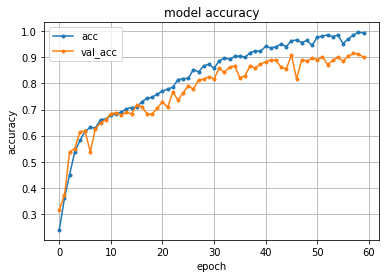

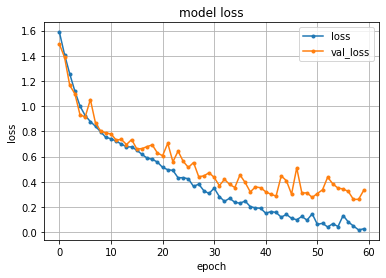

In [41]:
# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

In [ ]:
#予測
np.set_printoptions(precision=3)
acc_block = np.zeros([len(commands),len(commands)])

for i in range(len(Y_train)):
  pre_num = model.predict(X_train[i].reshape(1,DATA_LENGTH,14,1))
  tru_num = np.argmax(Y_train[i])
  acc_block[tru_num] = acc_block[tru_num] + pre_num
  if i%200 == 0:
    print('now:{}/{}'.format(i,len(Y_train)))
  
#百分率化%
Y_num = np.sum(Y_train,axis=0)
for i in range(len(Y_num)):
  acc_block[i] = (acc_block[i]*100)/Y_num[i]
#表示 横1段目(行)はneutralの判別割合(%), 2段目はstraightの...
print(acc_block)

In [36]:
test_data_path = "./{}/testdata".format(username)

all_files = os.listdir(test_data_path)

X_test = np.zeros((0, DATA_LENGTH, CHANNEL_NUMBER), float)
Y_test = np.zeros(0)
for commandIdx, command in enumerate(commands):
    specific_command_data_list = np.zeros((0, DATA_LENGTH, CHANNEL_NUMBER), float)
    specific_files = [s for s in all_files if command in s and '.csv' in s]
    for specific_file in specific_files:
        with open(test_data_path + "/" + specific_file) as f:
            reader = csv.reader(f)
            l = [row for row in reader]
        l = [[float(v) for v in row[3:3+CHANNEL_NUMBER]] for row in l[2:]] # EEGに該当する部分のみスライス
        l = np.array(l)
        l = l.astype(np.float)
        
        step = 0
        while IGNORE_LENGTH + STEP_SIZE * step + DATA_LENGTH < l.shape[0]:
            startIdx = IGNORE_LENGTH + STEP_SIZE * step
            endIdx = IGNORE_LENGTH + STEP_SIZE * step + DATA_LENGTH
            X_test = np.block([[[X_test]], [[normalize(l[startIdx:endIdx]).reshape(1, DATA_LENGTH, CHANNEL_NUMBER)]]])
            step += 1
        Y_test = np.append(Y_test, np.full(step, commandIdx))

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],X_test.shape[2], 1)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=len(commands))

In [42]:
# テストデータに対する精度
model.evaluate(X_test, Y_test)

1020/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.7697311311420373, 0.8352941]